In [3]:
import gc
import time
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
import click
from logzero import logger


def validate_model(data_name: str, n_thread: int):
    logger.info("Loading HDF...")
    click_data = pd.read_hdf("../data/{}.hdf".format(data_name), data_name)
    logger.info(click_data.dtypes)

    logger.info("Splitting data...")
    click_data.drop(columns=["click_id"], inplace=True)
    train = click_data[click_data["dow"] < 3]
    valid = click_data[click_data["dow"] == 3]

    del click_data
    gc.collect()

    y_train = train["is_attributed"].astype("int")
    train.drop(columns=["is_attributed"], inplace=True)
    y_valid = valid["is_attributed"].astype("int")
    valid.drop(columns=["is_attributed"], inplace=True)
    gc.collect()

    logger.info("Generating matrix...")
    dtrain = xgb.DMatrix(train, y_train)
    dvalid = xgb.DMatrix(valid, y_valid)

    del train, y_train, valid, y_valid
    gc.collect()

    logger.info("Validating...")
    params = {'eta': 0.6,
              'tree_method': "hist",
              'grow_policy': "lossguide",
              'max_leaves': 1400,
              'max_depth': 0,
              'subsample': 0.9,
              'colsample_bytree': 0.7,
              'colsample_bylevel': 0.7,
              'min_child_weight': 0,
              'alpha': 4,
              'objective': 'binary:logistic',
              'scale_pos_weight': 9,
              'eval_metric': 'auc',
              'nthread': n_thread,
              'random_state': 99,
              'silent': True}
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    model = xgb.train(params,
                      dtrain,
                      200,
                      watchlist,
                      maximize=True,
                      early_stopping_rounds=25,
                      verbose_eval=5)
    return model

In [4]:
model = validate_model("merged_click_data", 4)

[I 180423 03:21:15 <ipython-input-3-529ca6f846b7>:13] Loading HDF...
[I 180423 03:28:56 <ipython-input-3-529ca6f846b7>:15] app                                              uint16
    channel                                          uint16
    click_id                                        float64
    device                                           uint16
    ip                                               uint32
    is_attributed                                   float64
    os                                               uint16
    click_count_by_ip_os_device_dow                  uint32
    click_count_by_ip_os_device_dow_hour             uint16
    click_count_by_ip                                uint32
    dow                                               uint8
    hour                                              uint8
    minute                                            uint8
    second                                            uint8
    rank_by_ip                           

[0]	train-auc:0.966132	valid-auc:0.958773
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[5]	train-auc:0.97439	valid-auc:0.967524
[10]	train-auc:0.97983	valid-auc:0.970372
[15]	train-auc:0.979836	valid-auc:0.965836
[20]	train-auc:0.97631	valid-auc:0.961294
[25]	train-auc:0.976029	valid-auc:0.961066
[30]	train-auc:0.96866	valid-auc:0.954038
[35]	train-auc:0.969154	valid-auc:0.957246
Stopping. Best iteration:
[10]	train-auc:0.97983	valid-auc:0.970372



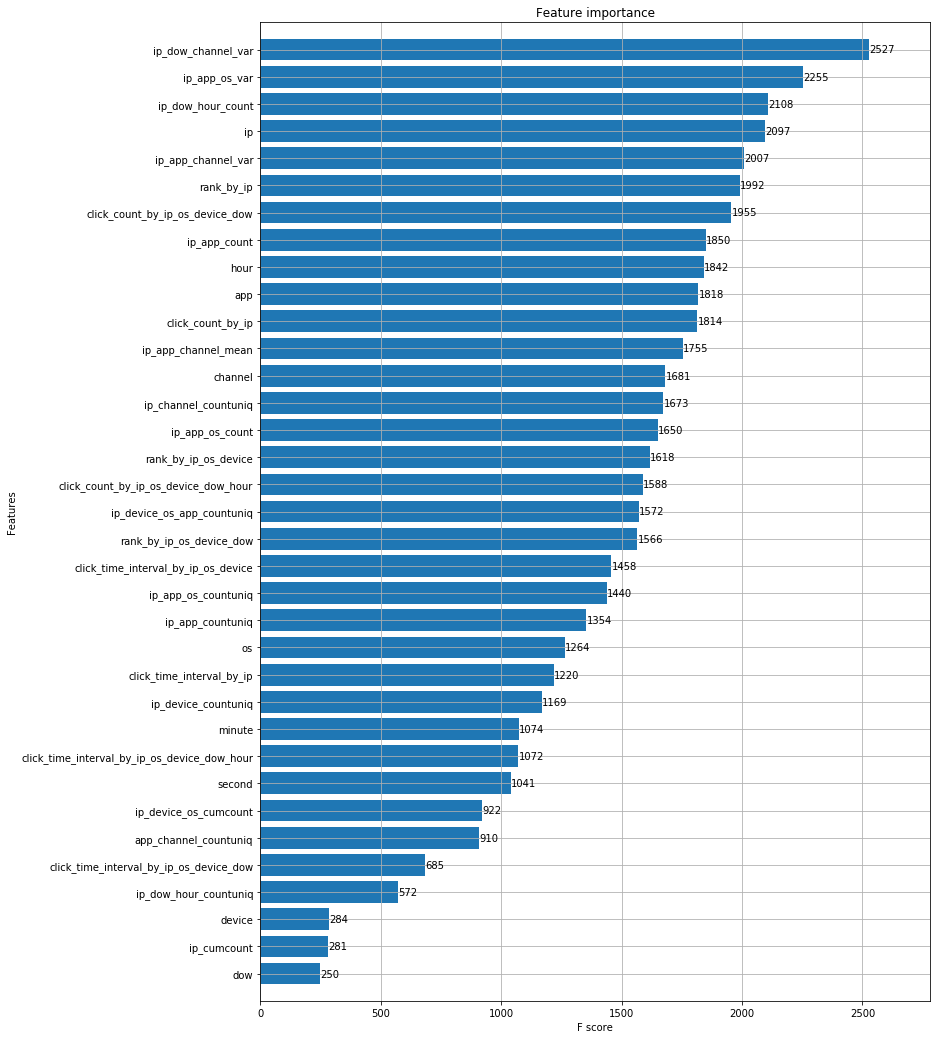

In [7]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

# Validation with split data

In [3]:
import gc
import time
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
import click
from logzero import logger

In [1]:
ls -lha ../data/

total 34G
drwxrwxr-x 2 ubuntu ubuntu 4.0K Apr 24 12:24 ./
drwxrwxr-x 7 ubuntu ubuntu 4.0K Apr 24 12:39 ../
-rw-rw-r-- 1 ubuntu ubuntu 4.8G Apr 24 12:10 basic_table.hdf
-rw-rw-r-- 1 ubuntu ubuntu 3.5G Apr 24 12:12 click_count_table.hdf
-rw-rw-r-- 1 ubuntu ubuntu 2.5G Apr 24 11:02 click_time_interval_ip_device_os_app_hash.hdf
-rw-rw-r-- 1 ubuntu ubuntu 5.4G Apr 24 12:13 intervals_table.hdf
-rw-rw-r-- 1 ubuntu ubuntu  12G Apr 24 12:16 misc_counts.hdf
-rw-rw-r-- 1 ubuntu ubuntu 3.8G Apr 24 12:14 ranks_table.hdf
-rw-rw-r-- 1 ubuntu ubuntu 2.3G Apr 24 12:15 time_table.hdf


In [4]:
%%time
click_data = pd.concat([
    pd.read_hdf("../data/basic_table.hdf", "basic_table"),
    pd.read_hdf("../data/click_count_table.hdf", "click_count_table"),
    pd.read_hdf("../data/click_time_interval_ip_device_os_app_hash.hdf", "click_time_interval_ip_device_os_app_hash"),
    pd.read_hdf("../data/intervals_table.hdf", "intervals_table"),
    pd.read_hdf("../data/misc_counts.hdf", "misc_counts"),
    pd.read_hdf("../data/ranks_table.hdf", "ranks_table"),
    pd.read_hdf("../data/time_table.hdf", "time_table"),
], axis=1)

CPU times: user 24 s, sys: 19 s, total: 43 s
Wall time: 43 s


In [5]:
logger.info(click_data.dtypes)

logger.info("Splitting data...")
click_data.drop(columns=["click_id"], inplace=True)
train = click_data[click_data["dow"] < 3]
valid = click_data[click_data["dow"] == 3]

del click_data
gc.collect()

[I 180424 12:51:31 <ipython-input-5-38d4aa681009>:1] app                                              uint16
    channel                                          uint16
    click_id                                         uint32
    device                                           uint16
    ip                                               uint32
    is_attributed                                     uint8
    os                                               uint16
    click_count_by_ip                                uint32
    click_count_by_ip_os_device_dow                  uint32
    click_count_by_ip_os_device_dow_hour             uint16
    click_time_interval_ip_device_os_app_hash        uint32
    first_click_interval_ip_device_os_app_hash         bool
    click_time_interval_by_ip                        uint32
    click_time_interval_by_ip_os_device              uint32
    click_time_interval_by_ip_os_device_dow          uint32
    click_time_interval_by_ip_os_device_dow_hour   

56

In [6]:
%%time
y_train = train["is_attributed"].astype("int")
train.drop(columns=["is_attributed"], inplace=True)
y_valid = valid["is_attributed"].astype("int")
valid.drop(columns=["is_attributed"], inplace=True)
gc.collect()

CPU times: user 12 s, sys: 6.59 s, total: 18.6 s
Wall time: 18.6 s


In [7]:
%%time
logger.info("Generating matrix...")
dtrain = xgb.DMatrix(train, y_train)
dvalid = xgb.DMatrix(valid, y_valid)

del train, y_train, valid, y_valid
gc.collect()

[I 180424 13:02:02 <timed exec>:1] Generating matrix...


CPU times: user 8min 2s, sys: 4min 51s, total: 12min 54s
Wall time: 12min 52s


In [8]:
%%time
n_thread = 32
logger.info("Validating...")
params = {'eta': 0.6,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 1400,
          'max_depth': 0,
          'subsample': 0.9,
          'colsample_bytree': 0.7,
          'colsample_bylevel': 0.7,
          'min_child_weight': 0,
          'alpha': 4,
          'objective': 'binary:logistic',
          'scale_pos_weight': 9,
          'eval_metric': 'auc',
          'nthread': n_thread,
          'random_state': 99,
          'silent': True}
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
model = xgb.train(params,
                  dtrain,
                  200,
                  watchlist,
                  maximize=True,
                  early_stopping_rounds=25,
                  verbose_eval=5)

[I 180424 13:28:55 <timed exec>:2] Validating...


[0]	train-auc:0.965956	valid-auc:0.958759
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[5]	train-auc:0.973265	valid-auc:0.966621
[10]	train-auc:0.979865	valid-auc:0.970299
[15]	train-auc:0.980639	valid-auc:0.96656
[20]	train-auc:0.977353	valid-auc:0.963054
[25]	train-auc:0.974564	valid-auc:0.962213
[30]	train-auc:0.975001	valid-auc:0.961963
[35]	train-auc:0.976633	valid-auc:0.95855
Stopping. Best iteration:
[10]	train-auc:0.979865	valid-auc:0.970299

CPU times: user 4h 18min 31s, sys: 4min 44s, total: 4h 23min 16s
Wall time: 20min 36s


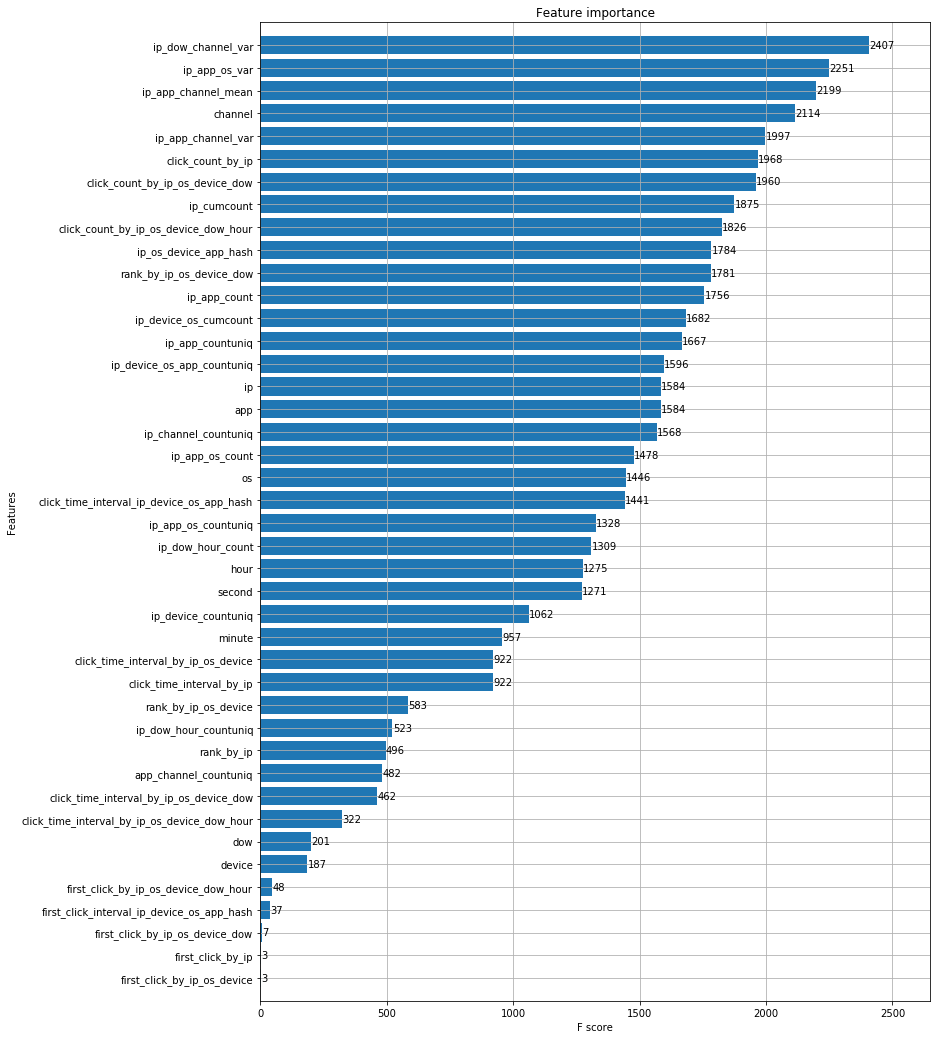

In [9]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()